# CROCO variable manipulation

This notebook explores how to manipulate CROCO variables using R_files,
R_vars and R_tools.

Note that is also possible to manipulate them using straight netcdf file but
this is not topic of this notebook.

**It is also a good way to check if your Pyticles simulation is correctly set in R_files.py
and Input_file.py**


- Find CROCO files using R_files
- Load CROCO variables using R_vars 
- Compute CROCO variables using R_tools


In [3]:
import sys
import numpy as np
import scipy.stats as st

import matplotlib.pyplot as plt

# --> project related modules
sys.path.append('../../Modules/')
#sys.path.append('../../pyticles/Modules/R_tools')

# --> where your simulation is defined (croco path etc...)
# see plot_strain_vorticity for more details
from R_files import load

# classic Roms_tools
import R_tools as tools

# some ROMS tools written in .F (much faster)
import R_tools_fort as toolsF

# Compute (Some) Croco variables
from R_vars import var

## Find CROCO files using Rfiles

Let's take POLGYR simulation for instance

Look at pyticles/Modules/R_files.py load Class documentation in the cell below

To initialize a simulation we need:

- a simulation name: `polgyr`

- optionaly coordinates to zoom: [iy_min, iy_max, ix_min, ix_max, ...]
 
  With zoom indices in rho-coordinates iy means eta dimension and ix xi-dimension
  
- optionaly a time to load: `0`

  time to load is in CROCO output time [unit]


```Bash
# example with gigatl 1h outputs only surface fields
parameters = "gigatl1_1h_surf [10500,11300,4750,5550,[1,300,1]] 36648"
simul = load(simul=parameters, output=False)
```

In [4]:
###########################
# Pick a simulation and time

simulname = 'polgyr'; 
time = 0

####################################
# Pick a grid point and a domain size
laty = 500
latx = 500
size = 400

###################################################################################
# Load simulation over the zoomed region
ix1 = np.max([0, latx-size])
ix2 = latx + size
iy1 = np.max([0, laty-size])
iy2 = laty + size

# --> to zoom over region
parameters = f"{simulname} [{iy1},{iy2},{ix1},{ix2},[1,300,1]] {time}"
print(f"parameters = {parameters}")
print()

simul = load(simul=parameters, output=False)

print(simul.date)

parameters = polgyr [100,900,100,900,[1,300,1]] 0

Jan 10 - 14:53


Note that simul is initialized like in Pyticles `Inputs/input_file.py`

Now to check if `input_file.py` is correct we can use the update method from R_files

let's initiate a `tstart` and look at fields that would be loaded by Pyticles.

For example if there is 2 years of spinup for CROCO simulation, 
I can start after these two years, with a dt = 12 hours, using 365 days/year
and with a dt=12h in CROCO outputs leads to tstart = 24*3600/dt * 2 * 365

In [5]:
simul.update(time=0)
print(f"CROCO initial date at tstart=0 {simul.year, simul.date}")
print(f"CROCO in file time-step {simul.infiletime}")
print(f"CROCO netcdf file {simul.ncfile}")
print(f"CROCO output time-step {simul.dt} [seconds] or {simul.dt/3600} [hours]")
print()

tstart = (24*3600/simul.dt * 2 * 365)
simul.update(time=tstart)
print(f"CROCO initial date at tstart={tstart} {simul.year, simul.date}")


time of simulation is: 0
/home/datawork-lops-osi/mlecorre/POLGYR/HIS/polgyr_his.00000.nc
CROCO initial date at tstart=0 (2001, 'Jan 10 - 14:53')
CROCO in file time-step 0
CROCO netcdf file /home/datawork-lops-osi/mlecorre/POLGYR/HIS/polgyr_his.00000.nc
CROCO output time-step 43200.0 [seconds] or 12.0 [hours]

time of simulation is: 1460
/home/datawork-lops-osi/mlecorre/POLGYR/HIS/polgyr_his.01460.nc
CROCO initial date at tstart=1460.0 (2003, 'Jan 10 - 14:53')


## Using rvars

In the header of `pyticles/Modules/R_tools/R_vars.py` we can see that 
salt, temp, rho, rho1, buoy, are defined in the dictionnary

In [6]:
# R_vars documentation
print(var.__doc__)

print("list of variables accessible with R_vars:")
var.dico

 
        This class is used to load/compute/interpolate any variable from the ROMS outputs

        and is used as follows: 
            myvar = R_vars.var(variable_name, simul)

        where variable_name is a string 
            (to see all valid variable names one should type: __???__ )

        where simul is a R_files object which has to include:
            simul.ncfile (path to netcdf file)
            simul.infiletime (time step (0,1,2...) in the netcdf file)
            simul.coord (subdomain coordinates [ny1,ny2,nx1,nx2,depths])
            

        NOTE that depths is used as follows:

        depth <= 0 means depths in meters
        depth = 0 means surface
        depth > 0 means sigma-level (1 = bottom [0 in netcdf file],...
                             ..., Nz = surface [Nz-1 in netcdf file])

                                    
    
list of variables accessible with R_vars:


{'temp': ['Temperature', '$T\\,(^{\\circ}C)$', [0, 0, 1]],
 'salt': ['Salinity', 'PSU', [0, 0, 1]],
 'u': ['u', 'm/s', [1, 0, 1]],
 'v': ['v', 'm/s', [0, 1, 1]],
 'ubar': ['ubar', 'm/s', [1, 0, -1]],
 'vbar': ['vbar', 'm/s', [0, 1, -1]],
 'zeta': ['SSH', '$\\eta\\,(m)$', [0, 0, -1]],
 'hbls': ['Thickness of KPP surface boundary layer', 'm', [0, 0, -1]],
 'hbbls': ['Thickness of KPP bottom boundary layer', 'm', [0, 0, -1]],
 'hbls_rho': ['Surface mixed-layer (based on rho = rhos+ 0.03)',
  'm',
  [0, 0, -1]],
 'hbls_t': ['Surface mixed-layer (based on t = ts - 0.2)', 'm', [0, 0, -1]],
 'AKt': ['Temperature vertical diffusion coef', 'm2/s', [0, 0, 0]],
 'AKv': ['Momentum vertical diffusion coef', 'm2/s', [0, 0, 0]],
 'omega': ['S-coordinate vertical velocity', 'm/s ?', [0, 0, 0]],
 'psi': ['psi', 'Streamfunction for depth integrated flow', [1, 1, -1]],
 'psi_surf': ['psi_surf', 'Streamfunction of surface flow', [1, 1, -1]],
 'rho': ['in-situ density', 'kg.m-3', [0, 0, 1]],
 'rho1': ['in-

## 

Note on R_vars and R_tools

R_vars returns a var object, with .data (array values) and some metadata.
To get the ndarray use var(...).data

    salt = var('salt', simul).data
    # salt is now a numpy.ndarray object

This will return a 3D variable with dimension xi_rho, eta_rho, s_rho 
(if netcdf file is 3D-time). Or 2D variable with dimension xi_rho, eta_rho 
if netcdf file contains 2D-time variables

To rephrase R_vars documentation, to extract a 2D field there are several options

    depth <= 0 means depths in meters
    depth = 0 means surface
    depth > 0 means sigma-level (1 = bottom [0 in netcdf file],...
                         ..., Nz = surface [Nz-1 in netcdf file])

<div class="alert alert-block alert-info">
<b>Warning:</b> all tools are Fortran based (CROCO ocean model is in Fortran) and Fortran
arrays are stored in Memory is the opposite way to Python. So croco data shall be
computed in Fortran order (do nothing) but displayed in C order (using np.transpose, or .T method)
</div>

    plt.pcolormesh(salt.T)

(800, 800, 80)


/dev/shm/pbs.6951645.datarmor0/ipykernel_48323/371096818.py:8: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(simul.x.T, simul.y.T, np.ma.masked_invalid(sst.T),


100 508 100 508
100 900 100 900
492 900 100 508
100 900 100 900
100 508 492 900
100 900 100 900
492 900 492 900
100 900 100 900


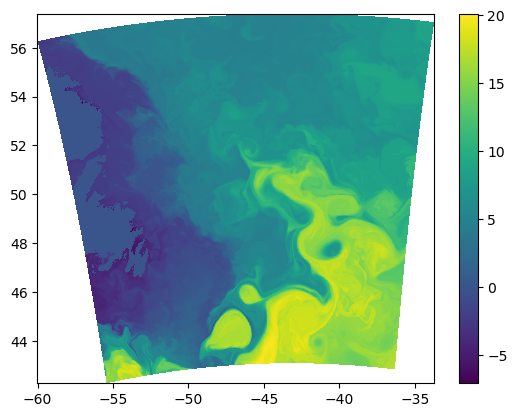

In [46]:
# takes 3D salinity at time tsart
salt = var('salt', simul).data
print(salt.shape)

# Get surface temperature
sst = var('temp', simul, depths=np.array([0])).data
plt.figure()
plt.pcolormesh(simul.x.T, simul.y.T, np.ma.masked_invalid(sst.T),
               rasterized=True)
plt.colorbar()

100 508 100 508
100 900 100 900
492 900 100 508
100 900 100 900
100 508 492 900
100 900 100 900
492 900 492 900
100 900 100 900


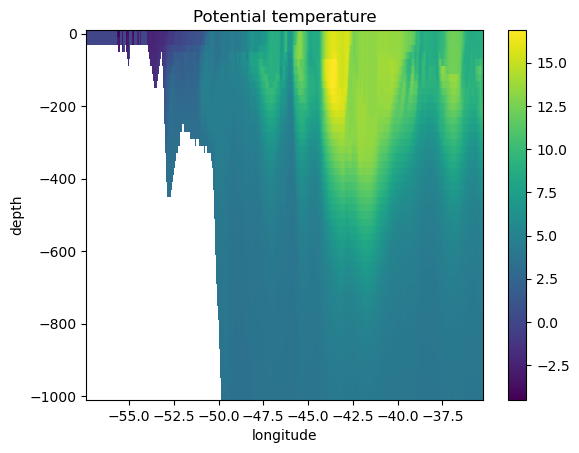

In [49]:
# vertical section at y = 400 in the first 1000 m depth
iy = 400
depths = np.arange(-1000, 0.1, 20)
z_temp = var('temp', simul, depths=depths).data

plt.figure()
[zy_plt, y_plt] = np.meshgrid(depths, simul.x[:, iy])
plt.pcolormesh(y_plt.T, zy_plt.T, z_temp[:, iy, :].T, rasterized=True)
plt.xlabel('longitude')
plt.ylabel('depth')
plt.title('Potential temperature')
plt.colorbar()

# Note for only a section, vertical interpolation of 2D fields
# can be time-consumming.
# A solution would habe been to use coord keyword argument to load a much 
# smaller portion of the domain.

## Gradient using R_tools and R_vars

Here we explore some usage of R_tools to compute some variables that may not
be present either in Netcdf files or in R_vars and tools

/dev/shm/pbs.6951645.datarmor0/ipykernel_48323/1043475345.py:14: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im0 = axes[0].pcolormesh(simul.x.T, simul.y.T, np.ma.masked_invalid(salt.T),
/dev/shm/pbs.6951645.datarmor0/ipykernel_48323/1043475345.py:17: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im1 = axes[1].pcolormesh(simul.x.T, simul.y.T, np.ma.masked_invalid(temp.T),


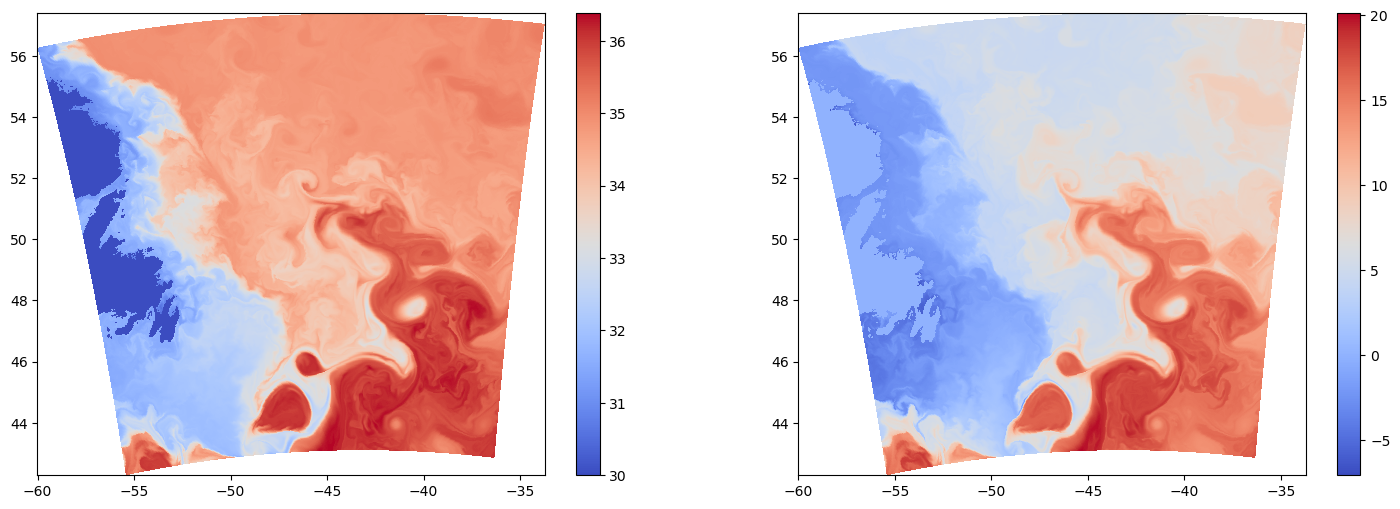

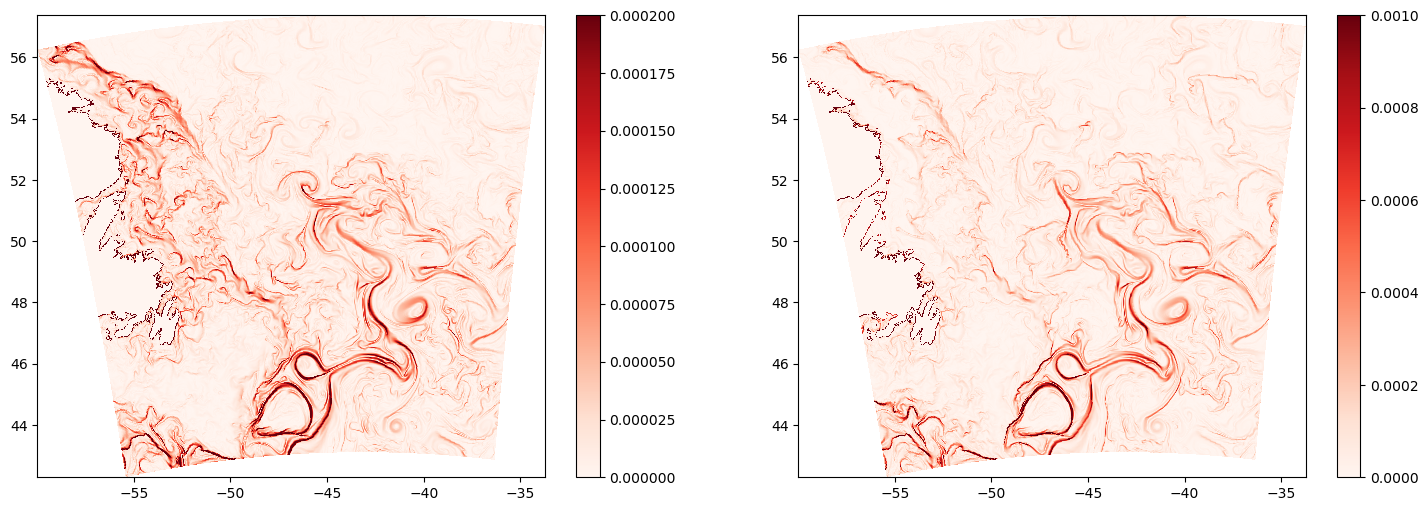

In [58]:
# --> compute surface density gradient
depths = np.array([0])
salt = var('salt', simul, depths=depths).data
temp = var('temp', simul, depths=depths).data

grad_salt = tools.grad(salt, simul.pm, simul.pn)
grad_temp = tools.grad(temp, simul.pm, simul.pn)

# --> plot vars
my_cmap = 'coolwarm'
sss_min = 30
sss_max = np.nanmax(salt)
fig, axes = plt.subplots(1, 2, figsize=(18.0, 6.0))
im0 = axes[0].pcolormesh(simul.x.T, simul.y.T, np.ma.masked_invalid(salt.T),
                   cmap=my_cmap, rasterized=True, vmin=sss_min, vmax=sss_max)
plt.colorbar(im0, ax=axes[0])
im1 = axes[1].pcolormesh(simul.x.T, simul.y.T, np.ma.masked_invalid(temp.T),
                   cmap=my_cmap, rasterized=True)
plt.colorbar(im1, ax=axes[1])

# --> plot gradients
levels_s = np.arange(0, 1.01, 0.01) * 2 * 1e-4
levels_r = np.arange(0, 1.01, 0.01) * 1e-3

my_cmap = 'Reds'
fig, axes = plt.subplots(1, 2, figsize=(18.0, 6.0))
im0 = axes[0].pcolormesh(simul.x.T, simul.y.T, np.ma.masked_invalid(grad_salt.T),
                         cmap='Reds', vmin=min(levels_s), vmax=max(levels_s),
                         rasterized=True)
plt.colorbar(im0, ax=axes[0])
im1 = axes[1].pcolormesh(simul.x.T, simul.y.T, np.ma.masked_invalid(grad_temp.T),
                         cmap='Reds',  vmin=min(levels_r), vmax=max(levels_r),
                         rasterized=True)
plt.colorbar(im1, ax=axes[1])

## Gradient for any CROCO variable

It is important to have in mind that CROCO variables are located on the Arakawa C-grid
https://www.myroms.org/wiki/File:grid_cell.png

    psi(i,j+1)---v(i,j+1)---psi(i+1, j+1)
     |                            |
     u(i,j)     rho(i,j)     u(i+1, j)
     |                            |
    psi(i,j)-----v(i,j)-----psi(i+1,j)
    
    
### Variables location:
- zeta, temp, salt, and any tracer are located at rho-points
- u is at u-points
- v is at v-points

### Operators
When using differential operators to a variable the result is located at the geometric center of the operator.
Example dx u => rho-points. So the divergence of 2d flow `dx u + dy v` is located at rho-points  

- vorticity ? dx v - dy u => psi-points

**To compute the proper gradient variables MUST BE at rho points**

R_tools provide a set of functions that interpolate variables from a grid location 
to another.

- `psi2rho`: interpolate a psi-variable to rho-points
- `u2rho`:  interpolate a u-variable to rho-points
- `v2rho`:  interpolate a v-variable to rho-pointsx

### Example with vorticity gradient

- Load vorticity from R_vars_gula.py or compute it "manually"
- Interpolate vort to rho points with R_tools
- Compute the gradient

In [60]:
%%time
depths = [0]
# --> using R_vars.py
vrt = tools.psi2rho(var('vrt', simul, depths=depths).data)
grad_vrt = tools.psi2rho(tools.grad(vrt, simul.pm, simul.pn))


depths [0] 0 vrt
computing vrt
100 504 100 504
100 900 100 900
depths [0] 0 vrt
computing vrt
496 900 100 504
100 900 100 900
depths [0] 0 vrt
computing vrt
100 504 496 900
100 900 100 900
depths [0] 0 vrt
computing vrt
496 900 496 900
100 900 100 900
CPU times: user 684 ms, sys: 376 ms, total: 1.06 s
Wall time: 1.36 s


/dev/shm/pbs.6951645.datarmor0/ipykernel_48323/2616577676.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(simul.x.T, simul.y.T, (vrt/simul.f).T,vmin=-2, vmax=2,
/dev/shm/pbs.6951645.datarmor0/ipykernel_48323/2616577676.py:9: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(simul.x.T, simul.y.T, (grad_vrt/simul.f).T,


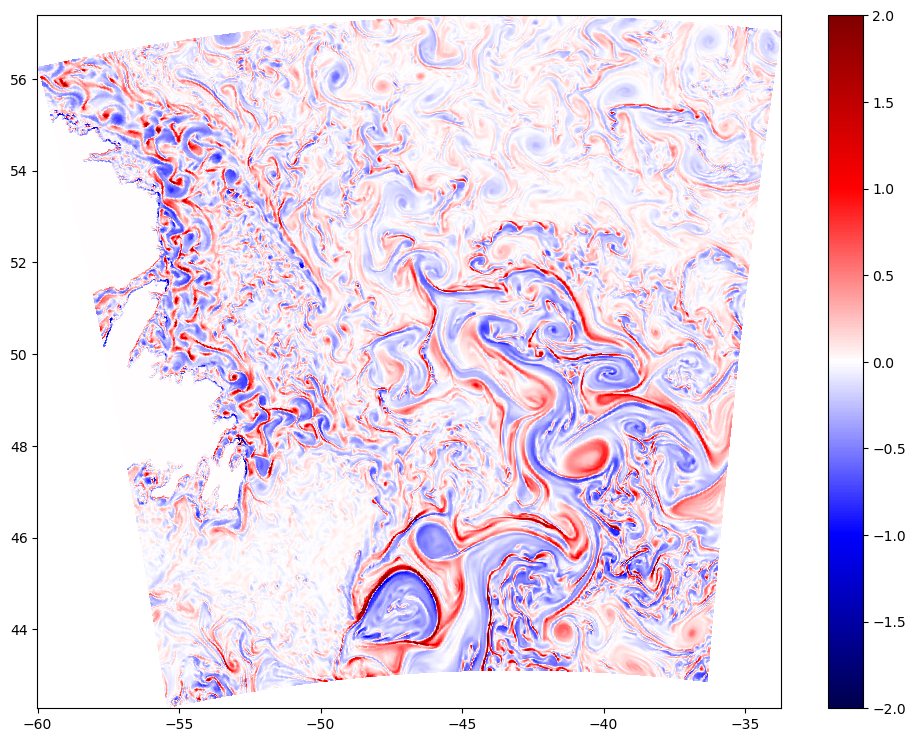

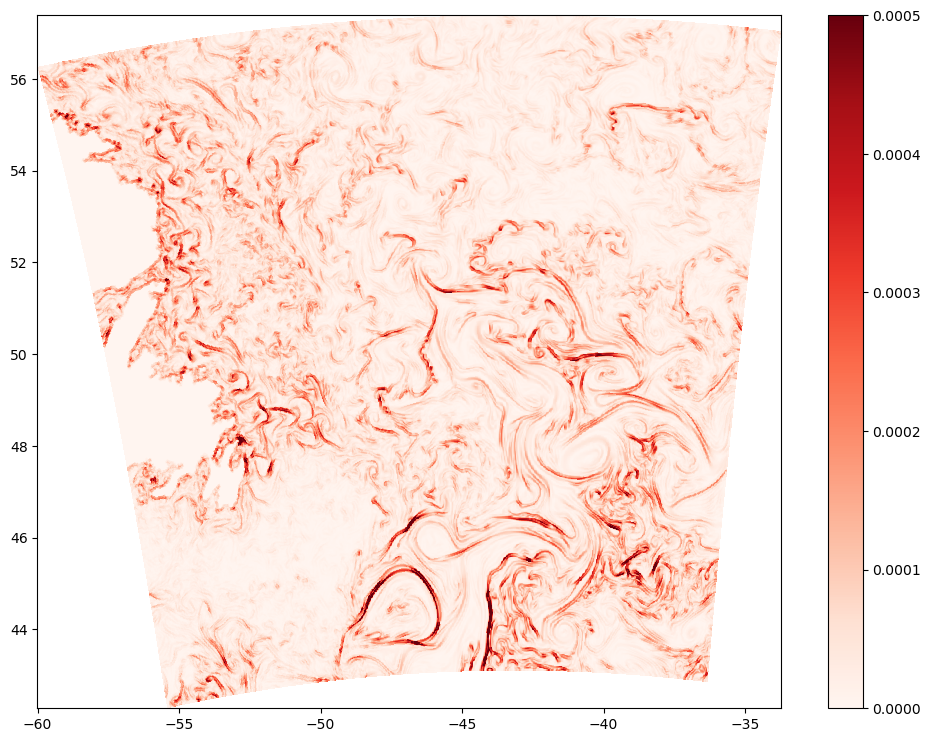

In [64]:
# --> display results
my_cmap = 'seismic'
plt.figure(figsize=(12, 9))
plt.pcolormesh(simul.x.T, simul.y.T, (vrt/simul.f).T,vmin=-2, vmax=2,
               cmap=my_cmap, rasterized=True)
plt.colorbar()

my_cmap = 'Reds'
plt.figure(figsize=(12, 9))
plt.pcolormesh(simul.x.T, simul.y.T, (grad_vrt/simul.f).T,
               vmin=None, vmax=0.5*1e-3, cmap=my_cmap, rasterized=True)
plt.colorbar()

In [65]:
%%time
# --> manually compute the gradient using R_tools operators
u = var('u', simul, depths=depths).data
v = var('v', simul, depths=depths).data

dxv = tools.diffx(v, tools.rho2v(simul.pm))
dyu = tools.diffy(u, tools.rho2u(simul.pn))

vrt = tools.psi2rho(dxv - dyu)/simul.f
grad_vrt = tools.psi2rho(tools.grad(vrt, simul.pm, simul.pn))

CPU times: user 316 ms, sys: 16 ms, total: 332 ms
Wall time: 438 ms


/dev/shm/pbs.6951645.datarmor0/ipykernel_48323/3287853647.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(simul.x.T, simul.y.T, grad_vrt,


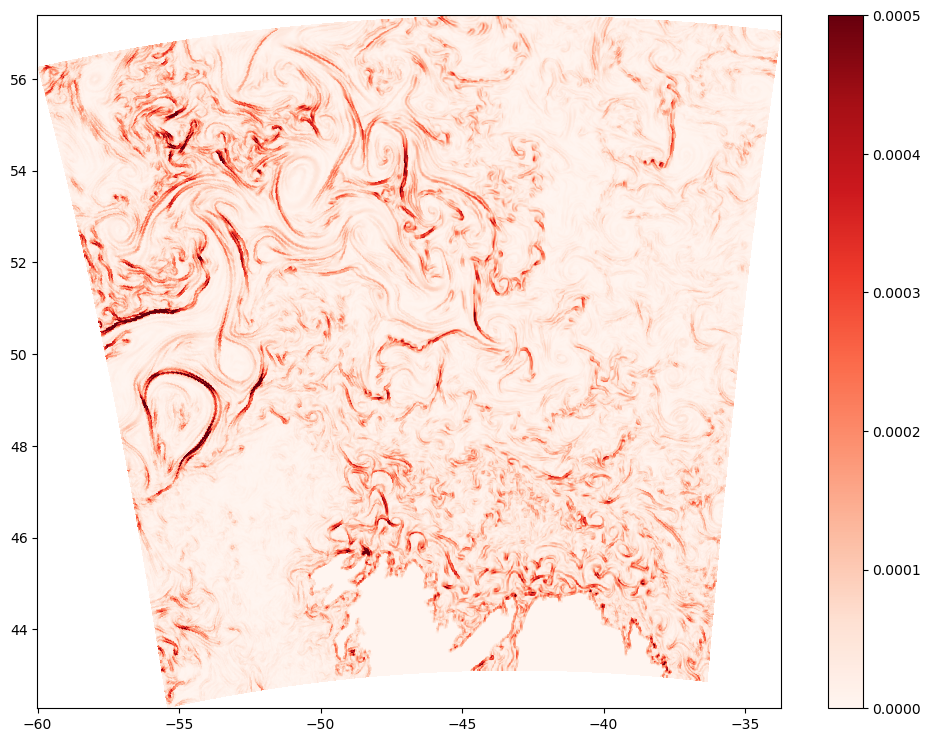

In [68]:
my_cmap = 'Reds'
plt.figure(figsize=(12, 9))
plt.pcolormesh(simul.x.T, simul.y.T, grad_vrt,
               vmin=None, vmax=0.5*1e-3, cmap=my_cmap, rasterized=True)
plt.colorbar()

### Note on operators

<div class="alert alert-block alert-info">
<b>Tip:</b>If a shape error occurs when computing variables, this is probably due
a grid location error
</div>


Example

In [70]:
u = var('u', simul, depths=depths).data
v = var('v', simul, depths=depths).data

dxv = tools.diffx(v, tools.rho2v(simul.pm))
dyu = tools.diffy(u, tools.rho2u(simul.pn))

try:
    # vrt is at psi point, but coriolis parameter is at rho points
    # Therefore shape of vrt is (nx_rho-1, nx_rho-1)
    vrt = (dxv - dyu)/simul.f
except Exception as e:
    print(e)
    # solution is to interpolate vrt from psi-points to rho-points
    vrt = tools.psi2rho(dxv - dyu)/simul.f
    
print(f"after interpolation vrt.shape={vrt.shape}")

operands could not be broadcast together with shapes (799,799) (800,800) 
after interpolation vrt.shape=(800, 800)
